 ST1510 PDAS CA2 Assignment Source File

 Name: Lee Hong Yi

 Admin Number: 2223010
 
 Class: DAAA/FT/1B/05

 ## Topic Question: How does humidity and temperature affect the amount of dengue cases?

 >Due to the nature at which the Dengue virus is transmitted, the actual goal of the analysis is not to see how temperature and humidity affect the spread of the disease, but instead finding out which temperatures and humidities are most conducive for the breeding of the Aedes mosquito.

>Using information gathered from research on the Aedes mosquito, it can be seen that a mosquito only becomes infective with the Dengue virus approximately 7 days after it has bitten a infected individual. Futhermore, as a newly hatched Aedes egg takes 6-7 days to grow into a adult, eggs laid by a Aedes mosquito will take 13-14 days to go from birth to being able to transmit the Dengue disease.

>Hence, the data for the dengue case count has to be delayed by 14 days, so that a accurate analysis on the most conducive weather for the breeding of the Aedes mosquito can be determined.

__In summary, the actual analysis is on which temperatures and humidities are the most conducive for the breeding of the Aedes mosquito in Singapore.__

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data files, initial cleaning and wrangling.

Importing data files for use, as well as selecting desired columns to analyze.

In [45]:
caseCount = pd.read_csv('./data/weekly-infectious-disease-bulletin-cases.csv')
station1weather = pd.read_csv('./data/angmokio.csv', dtype = {"Year":"str", "Month":"str", "Day":"str"})
station2weather = pd.read_csv('./data/changi.csv', dtype = {"Year":"str", "Month":"str", "Day":"str"})
station3weather = pd.read_csv('./data/tuassouth.csv', dtype = {"Year":"str", "Month":"str", "Day":"str"})

clean_station1weather = station1weather[["Station", "Year", "Month", "Day", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]]
clean_station2weather = station2weather[["Station", "Year", "Month", "Day", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]]
clean_station3weather = station3weather[["Station", "Year", "Month", "Day", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]]


Importing and cleanining humidity dataset, as well as renaming the columns to make them easier to refer to in future.

In [46]:
humidityData = pd.read_excel("./data/M890081.xlsx", header = 8)[0:11].transpose().set_index(0)
colNames = humidityData.head(1).transpose()
humidityData.columns =  colNames["Data Series"]
humidityData = humidityData[1:]
humidityDate = humidityData.index
humidityDate = pd.to_datetime(humidityDate, format = "%Y %b ")
humidityData["dateFixed"] = humidityDate
humidityData = humidityData.set_index("dateFixed")

humidityData = humidityData.rename(columns={"Air Temperature Means Daily Maximum (Degree Celsius)":"meanTempMax","Air Temperature Means Daily Minimum (Degree Celsius)":"meanTempMin","Air Temperature Absolute Extremes Maximum (Degree Celsius)":"extremeMeanTempMax","Air Temperature Absolute Extremes Minimum (Degree Celsius)":"extremeMeanTempMin","Total Rainfall (Millimetre)":"totalRainfall","Highest Daily Rainfall Total (Millimetre)":"peakDailyRainfall","Number Of Rainy Days (Number)":"noRainyDays","Bright Sunshine Daily Mean (Hour)":"hourOfSun","Minimum Relative Humidity (Per Cent)":"minHumidity","24 Hours Mean Relative Humidity (Per Cent)":"meanHumidityDaily"})
humidityData["meanTemp"] = (humidityData["meanTempMax"] + humidityData["meanTempMin"])/2
humidityData["averageRainfall"] = (humidityData["totalRainfall"]/ humidityData["noRainyDays"])
colOrder = ["meanTemp","averageRainfall","peakDailyRainfall", "meanHumidityDaily"]
clean_humidityData = humidityData[colOrder]

Cleaning weather datasets, as well as merging them with proper date strings.
In addition, the code below also creates a dataframe with data from all the weather stations.

In [47]:
dateDict = station1weather[["Year", "Month", "Day"]]
concatDates = dateDict["Year"].str.cat([dateDict["Month"], dateDict["Day"]], sep = "-")
dateDict.insert(3, "concatDate", concatDates)
pd.to_datetime(dateDict["concatDate"])

clean_station1weather = clean_station1weather.merge(dateDict, how = "inner")
clean_station2weather = clean_station2weather.merge(dateDict, how = "inner")
clean_station3weather = clean_station3weather.merge(dateDict, how = "inner")

colOrder = ["Station", "concatDate", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]
clean_station1weather = clean_station1weather[colOrder]
clean_station1weather = clean_station1weather.rename(columns = {"Daily Rainfall Total (mm)":"dailyRainfall", "Mean Temperature (°C)":"meanTemp"}).astype({"concatDate":"datetime64"})
clean_station2weather = clean_station2weather[colOrder]
clean_station2weather = clean_station2weather.rename(columns = {"Daily Rainfall Total (mm)":"dailyRainfall", "Mean Temperature (°C)":"meanTemp"}).astype({"concatDate":"datetime64"})
clean_station3weather = clean_station3weather[colOrder]
clean_station3weather = clean_station3weather.rename(columns = {"Daily Rainfall Total (mm)":"dailyRainfall", "Mean Temperature (°C)":"meanTemp"}).astype({"concatDate":"datetime64"})

clean_stationAllweather = pd.concat([clean_station1weather, clean_station2weather, clean_station3weather])

Merging all rainfall/temperature datasets so that they can be aggregated to obtain a approximate value for all of Singapore.

In [48]:
aggregratedRainfall = pd.DataFrame()
aggregratedRainfall["concatDate"] = pd.to_datetime(dateDict["concatDate"])
aggregratedRainfall = aggregratedRainfall.merge(clean_station1weather[["concatDate","dailyRainfall"]], how = "inner")
aggregratedRainfall = aggregratedRainfall.rename(columns = {"dailyRainfall":"angMoKio"})
aggregratedRainfall = aggregratedRainfall.merge(clean_station2weather[["concatDate","dailyRainfall"]], how = "inner")
aggregratedRainfall = aggregratedRainfall.rename(columns = {"dailyRainfall":"changi"})
aggregratedRainfall = aggregratedRainfall.merge(clean_station3weather[["concatDate","dailyRainfall"]], how = "inner")
aggregratedRainfall = aggregratedRainfall.rename(columns = {"dailyRainfall":"tuasSouth"})

aggregratedTemperature = pd.DataFrame()
aggregratedTemperature["concatDate"] = pd.to_datetime(dateDict['concatDate'])
aggregratedTemperature = aggregratedTemperature.merge(clean_station1weather[["concatDate","meanTemp"]], how = "inner")
aggregratedTemperature = aggregratedTemperature.rename(columns = {"meanTemp":"angMoKio"})
aggregratedTemperature = aggregratedTemperature.merge(clean_station2weather[["concatDate","meanTemp"]], how = "inner")
aggregratedTemperature = aggregratedTemperature.rename(columns = {"meanTemp":"changi"})
aggregratedTemperature = aggregratedTemperature.merge(clean_station3weather[["concatDate","meanTemp"]], how = "inner")
aggregratedTemperature = aggregratedTemperature.rename(columns = {"meanTemp":"tuasSouth"})

Averaging the datasets found in the earlier cells.

In [49]:
aggregratedRainfall["average"] = (aggregratedRainfall["angMoKio"] + aggregratedRainfall["changi"] + aggregratedRainfall["tuasSouth"])/3
aggregratedTemperature["average"] = (aggregratedTemperature["angMoKio"] + aggregratedTemperature["changi"] + aggregratedTemperature["tuasSouth"])/3
averageWeather = pd.DataFrame()
averageWeather["rainfall"] = aggregratedRainfall["average"]
averageWeather["temperature"] = aggregratedTemperature["average"]
averageWeather["fixedDate"] = aggregratedTemperature["concatDate"]

Cleaning the dengue dataset, especially regarding the date string provided, as well as seperating the desired data and placing it in it's own dataframe.
>As the number of cases for Dengue Haemorrhagic Fever are extremely low, the numbers will not have a large impact on the analysis of data, hence can be ignored.

In [50]:
caseCount["dateFixed"] = pd.to_datetime(caseCount["epi_week"] + "-0", format = '%Y-W%U-%w')
dengueCount = caseCount[caseCount['disease'] == "Dengue Fever"]

passByDF = pd.DataFrame()
for i in range (0, 7):
    passByDF = pd.concat([passByDF, dengueCount["epi_week"] + f"-{i}"])
passByDF["date"] = dengueCount["epi_week"]
passByDF["dateFixed"] = pd.to_datetime(passByDF[0], format = "%Y-W%U-%w")

dengueCount = dengueCount.merge(passByDF, left_on = "epi_week", right_on = "date")
dengueCount["delayedDate"] = dengueCount["dateFixed_y"] + pd.DateOffset(days = 14)
colOrder = ["dateFixed_y","epi_week", "no._of_cases", 0, "delayedDate"]
dengueCount = dengueCount[colOrder]
dengueCount = dengueCount.rename(columns={"no._of_cases":"no_of_cases", 0:"weekWithDay", "dateFixed_y":"dateFixed"})
dengueCount = dengueCount.set_index("dateFixed")

Checking if there any missing values in any of the datasets.

In [51]:
print(f"Are there missing values in the humidityData dataset: {humidityData.isna().values.any()}")
print(f"Are there missing values in the clean_station1weather dataset: {clean_station1weather.isna().values.any()}")
print(f"Are there missing values in the clean_station2weather dataset: {clean_station2weather.isna().values.any()}")
print(f"Are there missing values in the clean_station3weather dataset: {clean_station3weather.isna().values.any()}")
print(f"Are there missing values in the averageWeather dataset: {averageWeather.isna().values.any()}")
print(f"Are there missing values in the dengueCount dataset: {dengueCount.isna().values.any()}")

Are there missing values in the humidityData dataset: False
Are there missing values in the clean_station1weather dataset: True
Are there missing values in the clean_station2weather dataset: False
Are there missing values in the clean_station3weather dataset: True
Are there missing values in the averageWeather dataset: True
Are there missing values in the dengueCount dataset: False


Dropping missing values from the dataset.
> Filling in the missing values via pandas or statsmodels is not applicable here, as the weather is unpredictable. In addition, since we are attempting to predicit individual values, and not attempting to determine a trend to fill in the missing values, it is thus better to drop the missing data instead.

In [52]:
clean_station1weather = clean_station1weather.dropna()
clean_station3weather = clean_station3weather.dropna()
averageWeather = averageWeather.dropna()

As the last dataset starts from 2014, data from before then in all datasets will be dropped and ignored.

In [53]:
clean_humidityData = clean_humidityData["2014-01-01":]
dengueCount = dengueCount["2014-01-01":]

Changing all values to a numeric datatype where needed.

In [54]:
clean_humidityData = clean_humidityData.astype(float)

Combining all datasets together for easier analysis.

In [55]:
combinedAll = pd.DataFrame()
combinedAll["dateFixed"] = pd.to_datetime(dateDict["concatDate"])
combinedAll = pd.merge(combinedAll, dengueCount[["no_of_cases","delayedDate"]], left_on = "dateFixed", right_on = "delayedDate")
combinedAll = pd.merge(combinedAll, averageWeather, left_on = "dateFixed", right_on = "fixedDate")
combinedAll = pd.merge(combinedAll, clean_humidityData, on ="dateFixed") 
colOrder = ["dateFixed", "delayedDate", "no_of_cases", "rainfall", "temperature", "meanTemp", "averageRainfall", "peakDailyRainfall", "meanHumidityDaily"]
combinedAll = combinedAll[colOrder]

combinedCaseTemp = pd.DataFrame()
combinedCaseTemp["dateFixed"] = pd.to_datetime(dateDict["concatDate"])
combinedCaseTemp = pd.merge(combinedCaseTemp, dengueCount[["no_of_cases","delayedDate"]], left_on = "dateFixed", right_on = "delayedDate")
combinedCaseTemp = pd.merge(combinedCaseTemp, averageWeather, left_on = "dateFixed", right_on = "fixedDate")

combinedHumiCase = pd.DataFrame()
combinedHumiCase["dateFixed"]= pd.to_datetime(dateDict["concatDate"])
combinedHumiCase = pd.merge(combinedHumiCase,dengueCount[["no_of_cases","delayedDate"]], on ="dateFixed")
combinedHumiCase = pd.merge(combinedHumiCase, clean_humidityData, on = "dateFixed")

Resetting Seaborn style.

In [56]:
sns.set_style("darkgrid", {"grid.color":".6"})

## Describing and exporting final datasets.

(dengueCount, averageWeather, clean_humidityData, combinedAll, combinedCaseTemp, combinedHumiTemp)

>Note: averageWeather is used for the analysis where possible, as its data is reported on a daily basis, as compared to clean_humidity, which is reported on a monthly basis.

In [57]:
display(dengueCount.describe())
display(averageWeather.describe())
display(clean_humidityData.describe())
display(combinedAll.describe())
display(combinedCaseTemp.describe())
display(combinedHumiCase.describe())

dengueCount.to_csv("./data_exported/dengueCount.csv")
averageWeather.to_csv("./data_exported/averageWeather.csv")
clean_humidityData.to_csv("./data_exported/clean_humidityData.csv")
combinedAll.to_csv("./data_exported/combinedAll.csv")
combinedCaseTemp.to_csv("./data_exported/combinedCaseTemp.csv")
combinedHumiCase.to_csv("./data_exported/combinedHumiTemp.csv")


,no_of_cases
count,3294.000000
mean,292.318154
std,311.231807
min,24.000000
25%,79.000000
50%,211.000000
75%,370.000000
max,1791.000000


,rainfall,temperature
count,2383.000000,2383.000000
mean,5.661141,28.106994
std,9.091857,1.098407
min,0.000000,22.900000
25%,0.000000,27.400000
50%,1.266667,28.133333
75%,8.133333,28.950000
max,76.066667,30.800000


Data Series,meanTemp,averageRainfall,peakDailyRainfall,meanHumidityDaily
count,108.000000,108.000000,108.000000,108.000000
mean,28.587500,10.577273,41.590741,78.377778
std,0.669081,5.443194,25.312527,3.021831
min,26.450000,0.200000,0.200000,72.000000
25%,28.200000,7.329167,28.750000,76.500000
50%,28.650000,10.580000,38.100000,78.250000
75%,29.000000,12.680435,52.700000,80.000000
max,30.050000,40.752941,210.600000,86.600000


,no_of_cases,rainfall,temperature,meanTemp,averageRainfall,peakDailyRainfall,meanHumidityDaily
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,273.658228,5.619831,27.905907,28.668987,9.606891,37.184810,78.250633
std,291.753228,8.628658,1.114074,0.629627,4.117016,19.108564,3.285706
min,34.000000,0.000000,24.900000,26.900000,0.200000,0.200000,72.000000
25%,69.500000,0.000000,26.983333,28.250000,6.519139,23.100000,75.700000
50%,221.000000,1.000000,27.966667,28.650000,9.580000,34.000000,78.100000
75%,341.500000,8.366667,28.683333,29.100000,12.041667,47.100000,79.950000
max,1665.000000,32.666667,29.700000,30.050000,19.422222,92.200000,86.600000


,no_of_cases,rainfall,temperature
count,2369.000000,2369.000000,2369.000000
mean,278.025327,5.656916,28.119080
std,291.489204,9.094155,1.087300
min,24.000000,0.000000,22.900000
25%,75.000000,0.000000,27.400000
50%,217.000000,1.266667,28.166667
75%,367.000000,8.133333,28.966667
max,1791.000000,76.066667,30.800000


,no_of_cases,meanTemp,averageRainfall,peakDailyRainfall,meanHumidityDaily
count,83.000000,83.000000,83.000000,83.000000,83.000000
mean,276.771084,28.657831,9.998693,38.187952,78.233735
std,290.513856,0.649929,4.697652,19.435430,3.150814
min,24.000000,26.800000,0.200000,0.200000,72.000000
25%,76.500000,28.250000,6.629240,24.800000,75.800000
50%,219.000000,28.650000,9.688889,34.600000,78.100000
75%,370.000000,29.100000,12.591538,50.000000,79.950000
max,1791.000000,30.050000,30.107143,92.200000,86.300000


# Plotting graphs for analysis

Plotting line graph of all dengue cases.

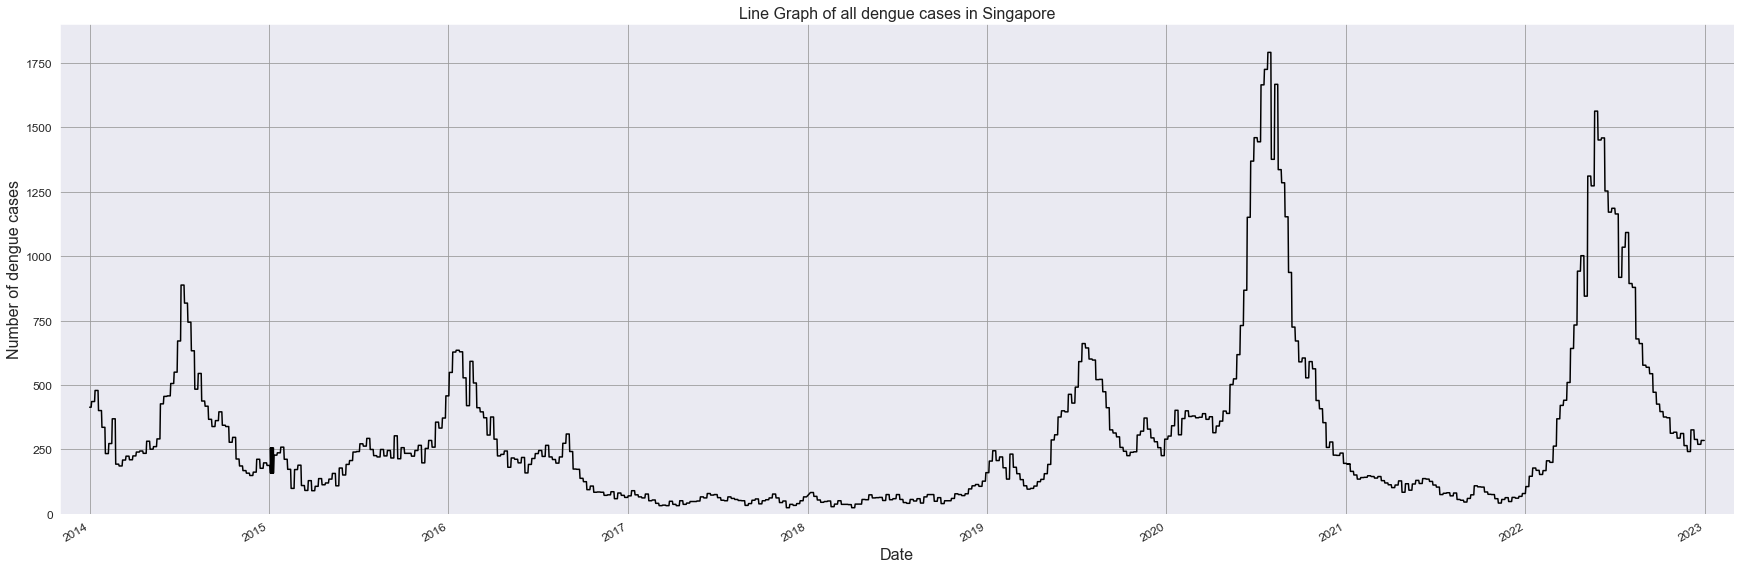

In [58]:
ax1 = dengueCount.plot(y = "no_of_cases", figsize = (30,10), fontsize = 12, color = "black", legend = False, use_index= True)
# plt.axvline(x = "2020-07-20", label = "1791 cases, during the week of 20 July 2020.", ymax = 0.94, color = "r")
# plt.axvline(x = "2022-05-23", label = "1563 cases, during the week of 06 June 2022.", ymax = 0.8226, color = "g")
ax1.margins(.05)
plt.axis(["2013-11-1", "2023-3-1", 0, 1900])
plt.ylabel("Number of dengue cases", fontdict={"size":16})
plt.xlabel("Date", fontdict={"size":16})
plt.title("Line Graph of all dengue cases in Singapore", fontdict={"size":16})

plt.show()

Plotting a regression model to visualize the relationship between rainfall and temperature.

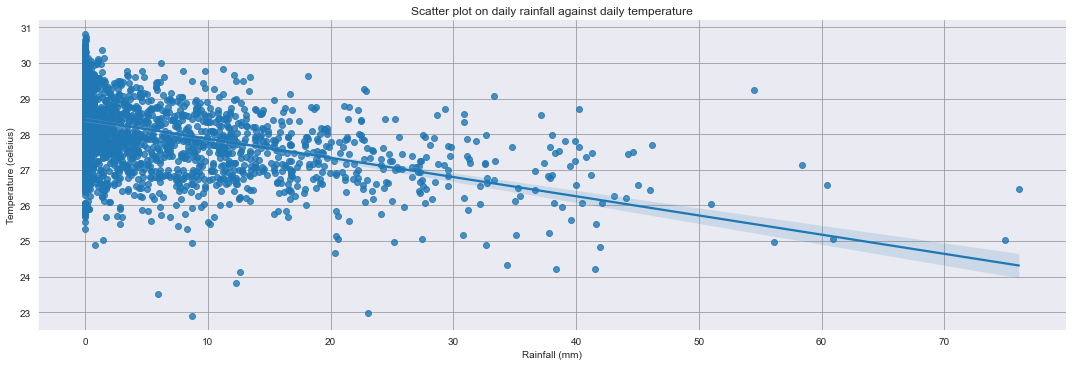

In [59]:
sns.lmplot(data = averageWeather, x = "rainfall",  y = "temperature", height = 5, aspect = 3)
plt.title("Scatter plot on daily rainfall against daily temperature")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Temperature (celsius)")
plt.show()


Visualizing the change in rainfall and humidity over the years.

Gradient of humidity best-fit line: 0.006082864138252948
Gradient of rainfall best-fit line: 0.025485070801155203


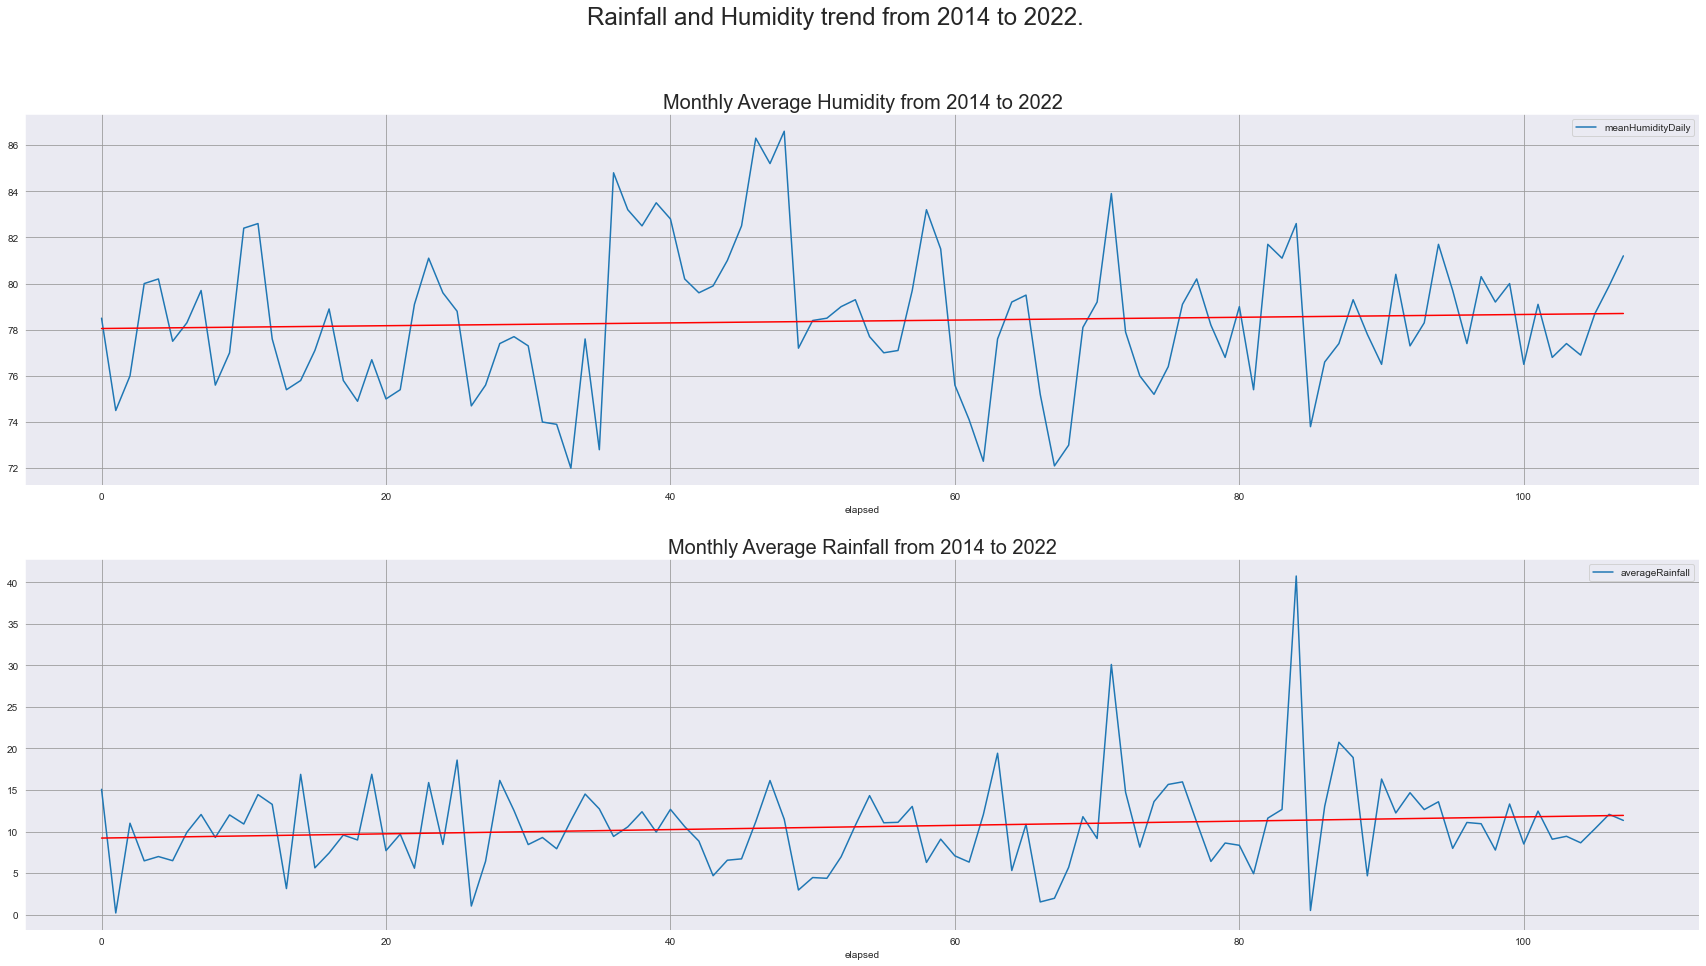

In [60]:
fig, ax = plt.subplots(2,1)
with pd.option_context('mode.chained_assignment', None):
    plt.suptitle("Rainfall and Humidity trend from 2014 to 2022.", fontsize = 24)
    plt.subplots_adjust(hspace = 0.2)

    clean_humidityData["elapsed"] = clean_humidityData.reset_index().index[::-1]
    clean_humidityData.plot(x = "elapsed", y = "meanHumidityDaily", figsize = (30,15), ax = ax[0])
    y = clean_humidityData["meanHumidityDaily"]
    y = pd.to_numeric(y)
    m,c = np.polyfit(clean_humidityData["elapsed"], y, deg = 1)
    print(f"Gradient of humidity best-fit line: {m}")
    ax[0].plot(clean_humidityData["elapsed"], m*clean_humidityData["elapsed"]+c, color = "red")
    ax[0].set_title("Monthly Average Humidity from 2014 to 2022", fontsize = 20)


    clean_humidityData["elapsed"] = clean_humidityData.reset_index().index[::-1]
    clean_humidityData.plot(x = "elapsed", y = "averageRainfall", figsize = (30,15), ax = ax[1])
    y = clean_humidityData["averageRainfall"]
    y = pd.to_numeric(y)
    m,c = np.polyfit(clean_humidityData["elapsed"], y, deg = 1)
    print(f"Gradient of rainfall best-fit line: {m}")
    ax[1].plot(clean_humidityData["elapsed"], m*clean_humidityData["elapsed"]+c, color = "red")
    ax[1].set_title("Monthly Average Rainfall from 2014 to 2022", fontsize = 20)


plt.show()

Intercept           -158.540192
temperature           61.061364
meanHumidityDaily    -16.252576
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            no_of_cases   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.737
Date:                Mon, 06 Feb 2023   Prob (F-statistic):             0.0115
Time:                        03:40:38   Log-Likelihood:                -555.35
No. Observations:                  79   AIC:                             1117.
Df Residuals:                      76   BIC:                             1124.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------

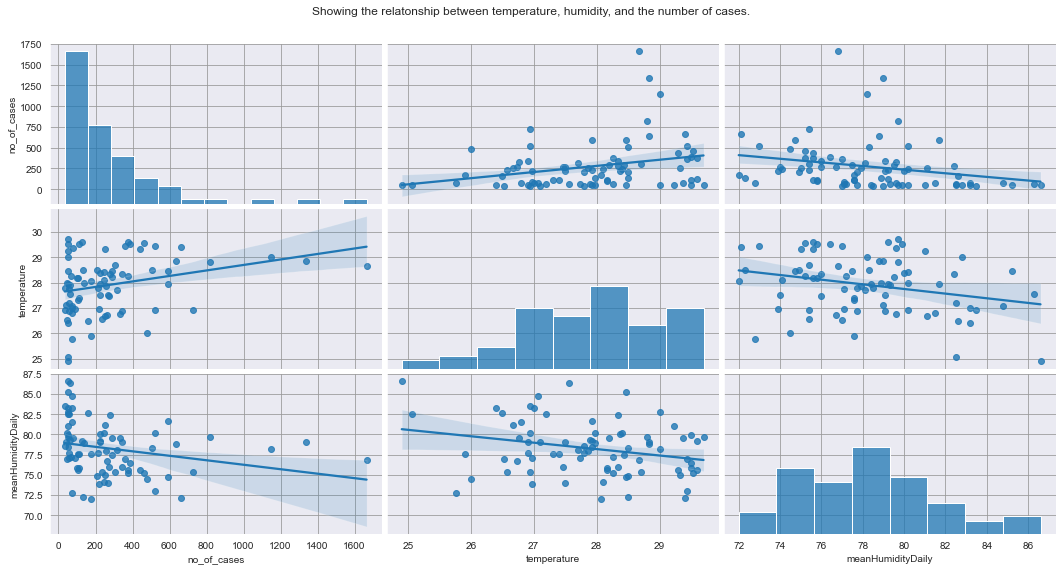

In [66]:
tempHumiCaseModel = sm.OLS.from_formula("no_of_cases ~ temperature + meanHumidityDaily", data = combinedAll).fit()
print(tempHumiCaseModel.params)
print(tempHumiCaseModel.summary())
g = sns.pairplot(combinedAll, x_vars = ["no_of_cases","temperature", "meanHumidityDaily"], y_vars = ["no_of_cases","temperature", "meanHumidityDaily"], kind = "reg", aspect = 2)
g.fig.suptitle("Showing the relatonship between temperature, humidity, and the number of cases.",  y = 1.05)
plt.show()

Intercept            1668.802271
meanHumidityDaily     -17.793234
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            no_of_cases   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.133
Date:                Mon, 06 Feb 2023   Prob (F-statistic):             0.0805
Time:                        03:39:52   Log-Likelihood:                -586.44
No. Observations:                  83   AIC:                             1177.
Df Residuals:                      81   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

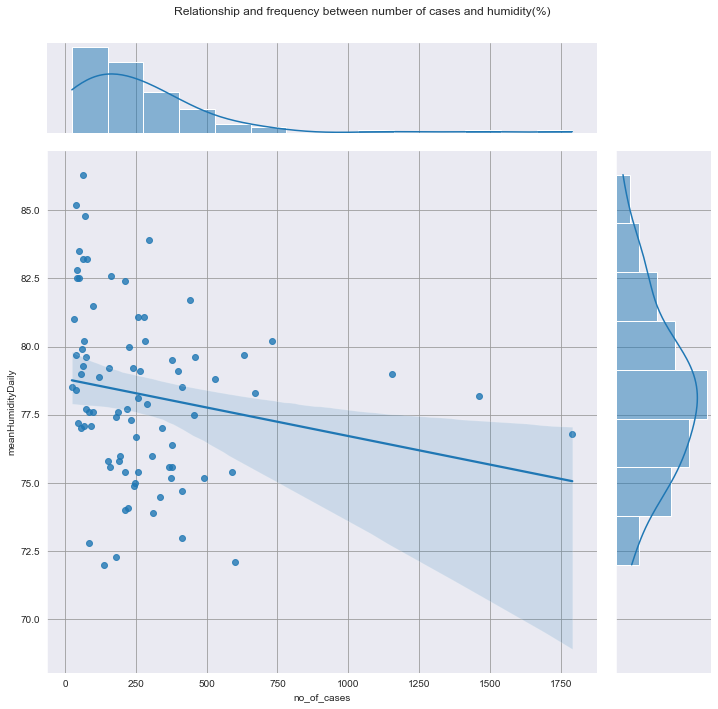

In [62]:
HumiCaseModel = sm.OLS.from_formula("no_of_cases ~ meanHumidityDaily", data = combinedHumiCase).fit()
print(HumiCaseModel.params)
print(HumiCaseModel.summary())
sns.jointplot(data = combinedHumiCase, x = "no_of_cases", y ="meanHumidityDaily", kind = "reg", height = 10)
plt.subplots_adjust(top = 0.93)
plt.suptitle('Relationship and frequency between number of cases and humidity(%)')
plt.show()

Intercept     -377.954212
temperature     23.328628
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            no_of_cases   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     18.06
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           2.22e-05
Time:                        03:39:53   Log-Likelihood:                -16796.
No. Observations:                2369   AIC:                         3.360e+04
Df Residuals:                    2367   BIC:                         3.361e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

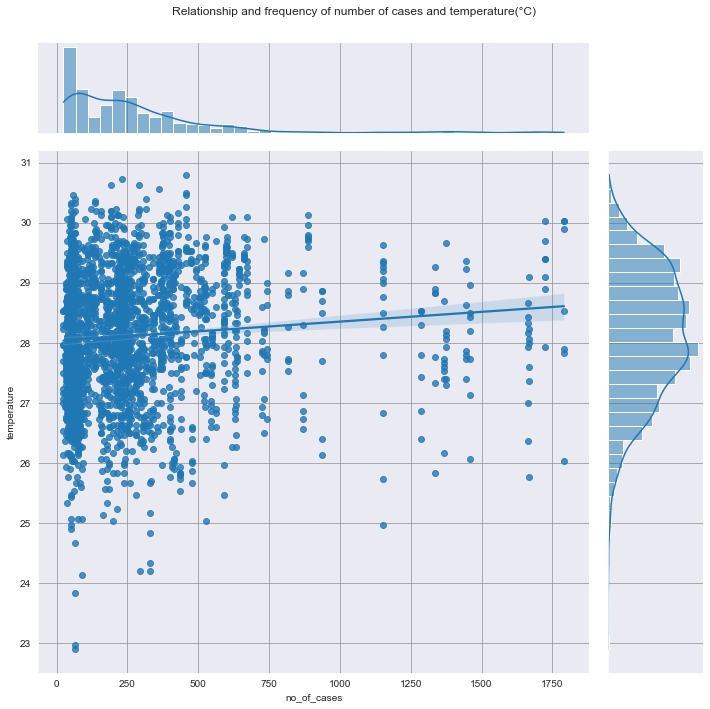

In [63]:
CaseTempModel = sm.OLS.from_formula("no_of_cases ~ temperature", data = combinedCaseTemp).fit()
print(CaseTempModel.params)
print(CaseTempModel.summary())
print(CaseTempModel.predict())
sns.jointplot(data = combinedCaseTemp, x = "no_of_cases", y ="temperature", kind = "reg", height = 10)
plt.subplots_adjust(top = 0.93)
plt.suptitle('Relationship and frequency of number of cases and temperature(°C)')
plt.show()

Gradient of best-fit line for cases compared to temperature is 0.0001291936578885731
Gradient of best-fit line for cases compared to humidity is -0.0027683006517716896


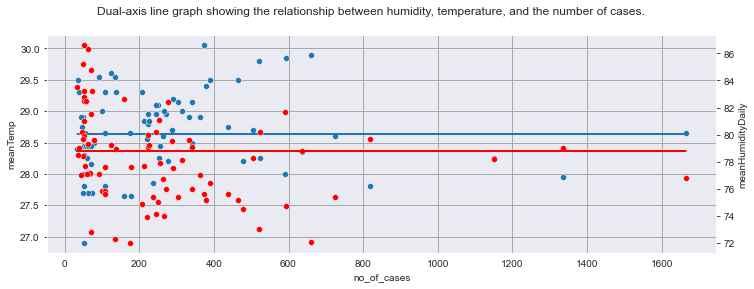

In [64]:
# Plot the first x and y axes:
fig, ax = plt.subplots(figsize= (12,4))
plt.suptitle('Dual-axis line graph showing the relationship between humidity, temperature, and the number of cases.')

ax = sns.scatterplot(data = combinedAll, y = "meanTemp", x = "no_of_cases")
m,c = np.polyfit(combinedAll["no_of_cases"], combinedAll["meanTemp"], deg = 1)
ax.plot(combinedAll["no_of_cases"], m*combinedAll["meanTemp"]+c)
print(f"Gradient of best-fit line for cases compared to temperature is {m}")


ax2 = ax.twinx()
sns.scatterplot(data = combinedAll, y = "meanHumidityDaily", x= "no_of_cases", ax = ax2, color = "red")
m,c = np.polyfit(combinedAll["no_of_cases"], combinedAll["meanHumidityDaily"], deg = 1)
ax2.plot(combinedAll["no_of_cases"], m*combinedAll["meanHumidityDaily"]+c, color = "red")
print(f"Gradient of best-fit line for cases compared to humidity is {m}")

ax2.grid(False)
plt.show()

Using the linear regression models created above, we can see that the correlation between humidity, temperature, and the number of cases are relatively weak in Singapore. From online research conducted, we can see that the optimum range for the Aedes mosquito to breed is between 27 and 29.5 degrees celsius, and when humidity is above 75%. As we can see from the data plotted above, we can see that Singapore is almost constantly within this weather range. Hence, we can conclude that as Singapore is almost within these range of conditions, there is no "optimum" range for the Aedes mosquito to breed in Singapore, as the rate at which they can breed is already at optimum.

Due to these findings, my conclusion is as follows.
As the weather does not play a factor in regards to the breeding of the Aedes mosquito in Singapore, the government can engage in more aggressive tactics to reduce the number of Aedes mosquitos, such as fumigation, releasing of <i>Wolbachia</i> infected mosquitoes, or spreading awareness on how to prevent the breeding of Aedes mosquitioes in households, such as the B-L-O-C-K method.

Links used: <br>
https://www.kaggle.com/datasets/cyanaspect/singapore-weather<br>
https://tablebuilder.singstat.gov.sg/table/TS/M890081<br>
https://storage.data.gov.sg/weekly-infectious-disease-bulletin-cases/resources/weekly-infectious-disease-bulletin-cases-2023-01-17T02-26-59Z.csv<br>
<br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3854883/#<br>